# Frequency-dependent complex absorber

## Without an absorber the solution is periodic

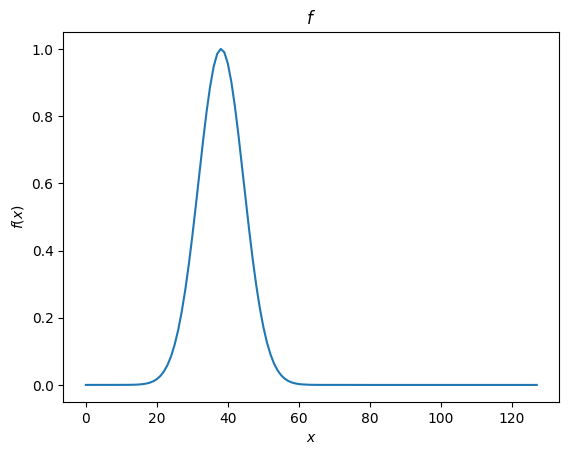

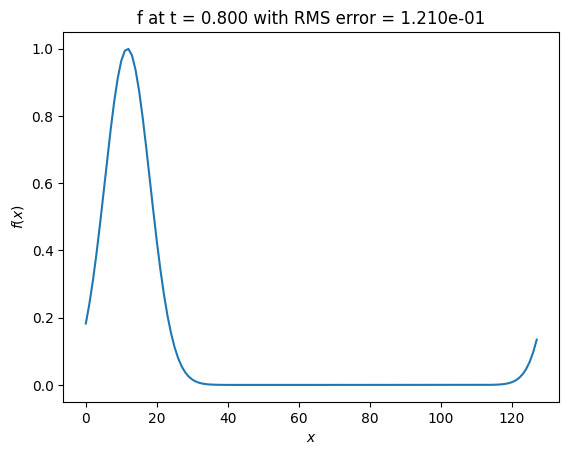

In [12]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt


L     = 1
N     = 128
x, dx = sd.computeX(0, L, N)
dt    = 1e-4
v     = 1
t     = 0
r     = (v * dt)**2

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

def UR(x, v, t):
    return np.exp(-(x-1.7 + t * v)**2/0.005)

t0   = 0.0
tend = 0.8

f  = func(x, v,   t0     )
fm = func(x, v,   t0 - dt)

ddfnum     = np.zeros(x.shape)
  
plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

BC = sd.PERIODIC

while t < tend:
    ddf, k          = sd.laplacianDtt1D(f, dx, BC)
    fp = 2 * f - fm + r * ddf
    fm = f
    f  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

## Implement absorber

In [ ]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt


L     = 1
N     = 128
x, dx = sd.computeX(0, L, N)
dt    = 1e-4
v     = 1
t     = 0
r     = (v * dt)**2

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

def UR(x, v, t):
    return np.exp(-(x-1.7 + t * v)**2/0.005)

t0   = 0.0
tend = 0.8

f  = func(x, v,   t0     )
fm = func(x, v,   t0 - dt)

ddfnum     = np.zeros(x.shape)
  
plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

BC = sd.PERIODIC

while t < tend:
    ddf, k          = sd.laplacianDtt1D(f, dx, BC)
    fp = 2 * f - fm + r * ddf
    fm = f
    f  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()